In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Imported Powerpoints/car-safety'    #project folder directory


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd 'gdrive/My Drive/Imported Powerpoints/car-safety'

/content/gdrive/My Drive/Imported Powerpoints/car-safety


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import json
import math
import requests
import numpy as np
import seaborn as sns
import matplotlib.pylab as pylab

params = {'legend.fontsize': '13',
          'figure.figsize': (20, 10),
         'axes.labelsize': '13',
         'axes.titlesize':'18',
         'xtick.labelsize':'13',
         'ytick.labelsize':'13'}
pylab.rcParams.update(pylab.rcParamsDefault)
pylab.rcParams.update(params)

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [0]:
df_tests = pd.read_csv('data/test.psv', sep = '|', encoding = 'unicode_escape')
df_vehicles = pd.read_csv('data/veh.psv', sep = '|', encoding = 'unicode_escape')
df_uk_accidents = pd.read_csv('data/uk_accidents.csv', encoding = 'unicode_escape')
df_uk_vehicles = pd.read_csv('data/uk_vehicles.csv', encoding = 'unicode_escape')
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')
df_uk_makes = pd.read_csv('data/Vehicle_Information.csv', usecols = [0, 10, 11, 19], encoding = 'unicode_escape')
df_matched_vehicles = pd.read_csv('matched_vehicles.csv', encoding = 'unicode_escape')
df_all_ratings = pd.read_csv('all_ratings.csv', encoding = 'unicode_escape')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Appending makes and models to the UK vehicles DF
if 'Vehicle_Make' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_makes, on = ['Accident_Index', 'Vehicle_Reference'], how='left')
    
# Rename vehicle make, model to follow the same convention
df_uk_vehicles.rename(columns={'make': 'Vehicle_Make', 'model': 'Vehicle_Model'}, inplace = True)


# Mapping numeric values to corresponding text
df_uk_vehicles_map = {
    'Sex_of_Driver': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Age_Band_of_Driver': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'}, 
    'Vehicle_Make': {'MISSING': np.nan},
    'Vehicle_Model': {'MISSING': np.nan},
    'Age_of_Vehicle': {-1: np.nan},
    '1st_Point_of_Impact': {-1: np.nan, 0.0:np.nan, 1: 'Front', 2: 'Back', 3: 'Offside', 4: 'Nearside'},
    'Vehicle_Manoeuvre': {-1: np.nan, 1: 'Reversing', 2: 'Parked', 3: 'Waiting to go - held up', 4: 'Slowing or stopping', 5: 'Moving off', 6: 'U-turn', 7: 'Turning left', 8: 'Waiting to turn left', 9: 'Turning right', 10: 'Waiting to turn right', 11: 'Changing lane to left', 12: 'Changing lane to right', 13: 'Overtaking moving vehicle – offside', 14: 'Overtaking static vehicle - offside', 15: 'Overtaking - nearside', 16: 'Going ahead left-hand bend', 17: 'Going ahead right-hand bend', 18: 'Going ahead other'},
    'Vehicle_Type': {-1: np.nan, 90: np.nan, 1: 'Pedal cycle', 2: 'Motorcycle <=50cc', 3: 'Motorcycle <=125cc', 4: 'Motorcycle 125cc-500cc', 5: 'Motorcycle >500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8-16 seats)', 11: 'Bus (>=17 seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van <=3.5 t.', 20: 'Goods 3.5t.-7.5t', 21: 'Goods >=7.5 t.', 22: 'Mobility scooter', 23: 'Electric motorcycle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight'},
    'Vehicle_Location-Restricted_Lane': {-1: np.nan, 0: 'On main carriageway - not in restricted lane', 1: 'Tram/Light rail track', 2: 'Bus lane', 3:	'Busway (including guided busway)', 4: 'Cycle lane (on main carriageway)', 5: 'Cycleway or shared use footway (not part of  main carriageway)', 6: 'On lay-by or hard shoulder', 7:	'Entering lay-by or hard shoulder', 8:	'Leaving lay-by or hard shoulder', 9: 'Footway (pavement)', 10:	'Not on carriageway'},
    'Junction_Location': {-1: np.nan, 0: 'Not at or within 20 metres of junction', 1:	'Approaching junction or waiting/parked at junction approach', 2:	'Cleared junction or waiting/parked at junction exit', 3:	'Leaving roundabout', 4: 'Entering roundabout', 5: 'Leaving main road', 6: 'Entering main road', 7:	'Entering from slip road', 8:	'Mid Junction - on roundabout or on main road'},
    'Skidding_and_Overturning': {-1: np.nan, 0: 'None', 1: 'Skidded', 2: 'Skidded and overturned', 3:	'Jackknifed', 4: 'Jackknifed and overturned', 5: 'Overturned'},
    'Hit_Object_in_Carriageway': {-1: np.nan, 11: np.nan, 0: 'None', 1: 'Previous accident', 2: 'Road works', 4: 'Parked vehicle', 5:	'Bridge (roof)', 6:	'Bridge (side)', 7:	'Bollard or refuge', 8:	'Open door of vehicle', 9: 'Central island of roundabout', 10: 'Kerb', 12: 'Any animal (except ridden horse)'}, 
    'Vehicle_Leaving_Carriageway': {-1: np.nan, 0: 'Did not leave carriageway', 1: 'Nearside', 2:	'Nearside and rebounded', 3: 'Straight ahead at junction', 4: 'Offside on to central reservation', 5:	'Offside on to centrl res + rebounded', 6: 'Offside - crossed central reservation', 7: 'Offside', 8: 'Offside and rebounded'},
    'Hit_Object_off_Carriageway': {-1: np.nan, 10: np.nan, 0: 'None', 1: 'Road sign or traffic signal', 2: 'Lamp post', 3: 'Telegraph or electricity pole', 4: 'Tree', 5:	'Bus stop or bus shelter', 6:	'Central crash barrier', 7:	'Near/Offside crash barrier', 8: 'Submerged in water', 9: 'Entered ditch', 11: 'Wall or fence'},
    'Journey_Purpose_of_Driver' : {-1: np.nan, 5: np.nan, 6: np.nan, 15: np.nan, 1:	'Journey as part of work', 2:	'Commuting to/from work', 3: 'Taking pupil to/from school', 4: 'Pupil riding to/from school'},
    'Age_of_Driver': {-1: np.nan},
    'Engine_Capacity_(CC)': {-1: np.nan},
    'Propulsion_Code': {-1: np.nan, 1: 'Petrol', 2: 'Heavy oil', 3: 'Electric', 4:	'Steam', 5:	'Gas', 6:	'Petrol/Gas (LPG)', 7: 'Gas/Bi-fuel', 8: 'Hybrid electric', 9: 'Gas Diesel', 10: 'New fuel technology', 11:	'Fuel cells', 12:	'Electric diesel'},
    'Driver_Home_Area_Type': {-1: np.nan, 1: 'Urban area', 2:	'Small town', 3: 'Rural'}
}


df_uk_accidents_map = {
    'Accident_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Weather_Conditions': {-1: np.nan, 8: np.nan, 9: np.nan, 1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist'},
    'Light_Conditions': {-1: np.nan, 1: 'Daylight', 4: 'Darkness - lights lit', 5: 'Darkness - lights unlit', 6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown'},
    'Police_Force': {1:	'Metropolitan Police', 3: 'Cumbria', 4:	'Lancashire', 5: 'Merseyside', 6:	'Greater Manchester', 7: 'Cheshire', 10: 'Northumbria', 11:	'Durham', 12:	'North Yorkshire', 13: 'West Yorkshire', 14: 'South Yorkshire', 16:	'Humberside', 17:	'Cleveland', 20: 'West Midlands', 21:	'Staffordshire', 22: 'West Mercia', 23:	'Warwickshire', 30: 'Derbyshire', 31:	'Nottinghamshire', 32: 'Lincolnshire', 33:	'Leicestershire', 34:	'Northamptonshire', 35:	'Cambridgeshire', 36:	'Norfolk', 37: 'Suffolk', 40:	'Bedfordshire', 41:	'Hertfordshire', 42: 'Essex', 43:	'Thames Valley', 44: 'Hampshire', 45:	'Surrey', 46:	'Kent', 47:	'Sussex', 48:	'City of London', 50:	'Devon and Cornwall', 52:	'Avon and Somerset', 53: 'Gloucestershire', 54:	'Wiltshire', 55: 'Dorset', 60: 'North Wales', 61:	'Gwent', 62: 'South Wales', 63:	'Dyfed-Powys', 91: 'Northern', 92: 'Grampian', 93: 'Tayside', 94:	'Fife', 95:	'Lothian and Borders', 96: 'Central', 97:	'Strathclyde', 98: 'Dumfries and Galloway'},
    'Day_of_Week': {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'},
    '1st_Road_Class': {6: np.nan, 1: 'Motorway', 2: 'A(M)', 3:	'A', 4:	'B', 5: 'C'},
    'Road_Type': {-1: np.nan, 9: np.nan, 1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 12: 'One way street/Slip road'},
    'Junction_Detail': {-1: np.nan, 9: np.nan, 0: 'Not at junction or within 20 metres', 1:	'Roundabout', 2: 'Mini-roundabout', 3: 'T or staggered junction', 5: 'Slip road', 6: 'Crossroads', 7: 'More than 4 arms (not roundabout)', 8:	'Private drive or entrance'},
    'Junction_Control': {-1: np.nan, 0:	'Not at junction or within 20 metres', 1:	'Authorised person', 2:	'Auto traffic signal', 3:	'Stop sign', 4:	'Give way or uncontrolled'},
    '2nd_Road_Class': {-1: np.nan, 6: np.nan, 0: 'Not at junction or within 20 metres', 1: 'Motorway', 2:	'A(M)', 3: 'A', 4: 'B',	5: 'C'},
    'Pedestrian_Crossing-Human_Control': {-1: np.nan, 0: 'None within 50 metres', 1: 'Control by school crossing patrol', 2: 'Control by other authorised person'},
    'Pedestrian_Crossing-Physical_Facilities': {-1: np.nan, 0: 'No physical crossing facilities within 50 metres', 1: 'Zebra', 4:	'Pelican, puffin, toucan or similar non-junction pedestrian light crossing', 5:	'Pedestrian phase at traffic signal junction', 7:	'Footbridge or subway', 8: 'Central refuge'},
    'Road_Surface_Conditions': {-1: np.nan, 1: 'Dry', 2: 'Wet or damp', 3: 'Snow', 4:	'Frost or ice', 5: 'Flood over 3cm. deep', 6: 'Oil or diesel', 7:	'Mud'},
    'Special_Conditions_at_Site': {-1: np.nan, 0:	'None', 1: 'Auto traffic signal - out', 2: 'Auto signal part defective', 3:	'Road sign or marking defective or obscured', 4: 'Roadworks', 5: 'Road surface defective', 6:	'Oil or diesel', 7: 'Mud'},
    'Carriageway_Hazards': {-1: np.nan, 0: 'None', 1: 'Vehicle load on road', 2: 'Other object on road', 3:	'Previous accident', 4:	'Dog on road', 5:	'Other animal on road', 6: 'Pedestrian in carriageway - not injured', 7: 'Any animal in carriageway (except ridden horse)'},
    'Urban_or_Rural_Area': {3: np.nan, 1: 'Urban', 2:	'Rural'},
    'Did_Police_Officer_Attend_Scene_of_Accident': {-1: np.nan, 1: 'Yes', 2: 'No', 3: 'No - accident was reported using a self completion  form (self rep only)'}
}

df_uk_casualties_map = {
    'Casualty_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Sex_of_Casualty': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Casualty_Class': {-1: np.nan, 1: 'Driver or rider', 2: 'Passenger', 3: 'Pedestrian'},
    'Age_of_Casualty': {-1: np.nan },
    'Age_Band_of_Casualty': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'},
    'Pedestrian_Location': {-1: np.nan, 10: np.nan, 0: 'Not a Pedestrian', 1:	'Crossing on pedestrian crossing facility', 2: 'Crossing in zig-zag approach lines', 3: 'Crossing in zig-zag exit lines', 4: 'Crossing elsewhere within 50m. of pedestrian crossing', 5: 'In carriageway, crossing elsewhere', 6:	'On footway or verge', 7:	'On refuge, central island or central reservation', 8: 'In centre of carriageway - not on refuge, island or central reservation', 9: 'In carriageway, not crossing'},
    'Pedestrian_Movement': {-1: np.nan, 9: np.nan, 0:	'Not a Pedestrian', 1: 'Crossing from driver nearside', 2: 'Crossing from nearside - masked by parked or stationary vehicle', 3: 'Crossing from driver offside', 4: 'Crossing from offside - masked by  parked or stationary vehicle', 5: 'In carriageway, stationary - not crossing  (standing or playing)', 6: 'In carriageway, stationary - not crossing  (standing or playing) - masked by parked or stationary vehicle', 7: 'Walking along in carriageway, facing traffic', 8:	'Walking along in carriageway, back to traffic'},
    'Car_Passenger': {-1: np.nan, 0: 'Not car passenger', 1: 'Front seat passenger', 2:	'Rear seat passenger'},
    'Bus_or_Coach_Passenger': {-1: np.nan, 0: 'Not a bus or coach passenger', 1: 'Boarding', 2:	'Alighting', 3:	'Standing passenger', 4: 'Seated passenger'},
    'Pedestrian_Road_Maintenance_Worker': {-1: np.nan, 2: np.nan, 0: 'No / Not applicable', 1: 'Yes'},
    'Casualty_Type': {-1:np.nan, 0:	'Pedestrian', 1: 'Cyclist', 2: 'Motorcycle 50cc and under rider or passenger', 3: 'Motorcycle 125cc and under rider or passenger', 4:	'Motorcycle over 125cc and up to 500cc rider or  passenger', 5:	'Motorcycle over 500cc rider or passenger', 8: 'Taxi/Private hire car occupant', 9:	'Car occupant', 10:	'Minibus (8 - 16 passenger seats) occupant', 11: 'Bus or coach occupant (17 or more pass seats)', 16:	'Horse rider', 17: 'Agricultural vehicle occupant', 18:	'Tram occupant', 19: 'Van / Goods vehicle (3.5 tonnes mgw or under) occupant', 20: 'Goods vehicle (over 3.5t. and under 7.5t.) occupant', 21:	'Goods vehicle (7.5 tonnes mgw and over) occupant', 22:	'Mobility scooter rider', 23:	'Electric motorcycle rider or passenger', 90:	'Other vehicle occupant', 97:	'Motorcycle - unknown cc rider or passenger', 98: 'Goods vehicle (unknown weight) occupant'}
}

for key in df_uk_vehicles_map:
    for old_value in df_uk_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_uk_vehicles_map[key][old_value])
for key in df_uk_accidents_map:
    for old_value in df_uk_accidents_map[key]:
        df_uk_accidents[key] = df_uk_accidents[key].replace(old_value, df_uk_accidents_map[key][old_value])
for key in df_uk_casualties_map:
    for old_value in df_uk_casualties_map[key]:
        df_uk_casualties[key] = df_uk_casualties[key].replace(old_value, df_uk_casualties_map[key][old_value])

# Converting UK Accident_Index to string
df_uk_vehicles.Accident_Index = df_uk_vehicles.Accident_Index.astype(str)
df_uk_accidents.Accident_Index = df_uk_accidents.Accident_Index.astype(str)
df_uk_casualties.Accident_Index = df_uk_casualties.Accident_Index.astype(str)

# Converting UK number columns to floats
df_uk_vehicles.Age_of_Vehicle = df_uk_vehicles.Age_of_Vehicle.astype(float)

# Calculating vehicle year from age_of_vehicle and accident date
if 'Vehicle_Year' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index', 'Date']], on = ['Accident_Index'], how='left')
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'].astype(float)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'] - df_uk_vehicles.Age_of_Vehicle  
    
# Dropping unneccessary columns
df_uk_vehicles.drop(columns = ['Date', 'Towing_and_Articulation', 'Was_Vehicle_Left_Hand_Drive?', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'], inplace = True, errors = 'ignore')
df_uk_accidents.drop(columns = ['Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], inplace = True, errors = 'ignore')
df_uk_casualties.drop(columns = ['Casualty_Home_Area_Type', 'Casualty_IMD_Decile'], inplace = True, errors = 'ignore')

## Clustering Analysis for UK Vehicles dataset

In [0]:
df_ncap_uk_n = df_uk_vehicles.copy(deep =True)

In [0]:
df_ncap_uk_n.head(10)

,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,Vehicle_Make,Vehicle_Model,Vehicle_Year
0,2017010001708,1,Car,Going ahead other,On main carriageway - not in restricted lane,Not at or within 20 metres of junction,None,None,Did not leave carriageway,None,Front,NaN,Male,24.000,21-25,1997.000,Heavy oil,1.000,NaN,NaN,NaN,2016.000
1,2017010001708,2,Motorcycle <=50cc,Going ahead other,On main carriageway - not in restricted lane,Not at or within 20 metres of junction,Skidded,None,Did not leave carriageway,None,Back,NaN,Male,19.000,16-20,nan,NaN,nan,NaN,NaN,NaN,nan
2,2017010009342,1,Car,Going ahead other,On main carriageway - not in restricted lane,Approaching junction or waiting/parked at junc...,None,None,Did not leave carriageway,None,Back,NaN,Male,33.000,26-35,1797.000,Hybrid electric,8.000,Urban area,NaN,NaN,2009.000
3,2017010009342,2,Car,Going ahead other,On main carriageway - not in restricted lane,Approaching junction or waiting/parked at junc...,Skidded,None,Did not leave carriageway,None,Front,NaN,Male,40.000,36-45,2204.000,Heavy oil,12.000,Urban area,NaN,NaN,2005.000
4,2017010009344,1,Car,Going ahead other,On main carriageway - not in restricted lane,Approaching junction or waiting/parked at junc...,None,None,Did not leave carriageway,None,Front,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,NaN,nan
5,2017010009344,2,Car,Going ahead other,On main carriageway - not in restricted lane,Cleared junction or waiting/parked at junction...,None,None,Did not leave carriageway,None,Front,NaN,Male,35.000,26-35,1896.000,Heavy oil,9.000,NaN,NaN,NaN,2008.000
6,2017010009344,3,Car,Going ahead other,On main carriageway - not in restricted lane,Cleared junction or waiting/parked at junction...,None,None,Did not leave carriageway,None,Front,NaN,Female,31.000,26-35,1299.000,Petrol,14.000,Urban area,NaN,NaN,2003.000
7,2017010009348,1,Car,Going ahead other,On main carriageway - not in restricted lane,Entering roundabout,None,Central island of roundabout,Did not leave carriageway,None,Front,NaN,Female,37.000,36-45,1399.000,Petrol,9.000,Urban area,NaN,NaN,2008.000
8,2017010009348,2,Car,Turning right,On main carriageway - not in restricted lane,Leaving roundabout,None,None,Did not leave carriageway,None,Offside,NaN,Female,29.000,26-35,1797.000,Hybrid electric,6.000,Urban area,NaN,NaN,2011.000
9,2017010009350,1,Car,Going ahead other,On main carriageway - not in restricted lane,Cleared junction or waiting/parked at junction...,None,None,Did not leave carriageway,None,Offside,NaN,Male,78.000,Over 75,1988.000,Petrol,14.000,Urban area,NaN,NaN,2003.000


In [0]:
df_dropped_na = df_ncap_uk_n.dropna()

In [0]:
df_dropped_na.dtypes

Accident_Index                       object
Vehicle_Reference                     int64
Vehicle_Type                         object
Vehicle_Manoeuvre                    object
Vehicle_Location-Restricted_Lane     object
Junction_Location                    object
Skidding_and_Overturning             object
Hit_Object_in_Carriageway            object
Vehicle_Leaving_Carriageway          object
Hit_Object_off_Carriageway           object
1st_Point_of_Impact                  object
Journey_Purpose_of_Driver            object
Sex_of_Driver                        object
Age_of_Driver                       float64
Age_Band_of_Driver                   object
Engine_Capacity_(CC)                float64
Propulsion_Code                      object
Age_of_Vehicle                      float64
Driver_Home_Area_Type                object
Vehicle_Make                         object
Vehicle_Model                        object
Vehicle_Year                        float64
dtype: object

In [0]:
df_dropped_na['Vehicle_Year'] = df_dropped_na['Vehicle_Year'].astype(int)
df_dropped_na['Age_of_Driver'] = df_dropped_na['Age_of_Driver'].astype(int)
df_dropped_na['Engine_Capacity_(CC)'] = df_dropped_na['Engine_Capacity_(CC)'].astype(int)
df_dropped_na['Age_of_Vehicle'] = df_dropped_na['Age_of_Vehicle'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [0]:
df_dropped_na.dtypes

Accident_Index                      object
Vehicle_Reference                    int64
Vehicle_Type                        object
Vehicle_Manoeuvre                   object
Vehicle_Location-Restricted_Lane    object
Junction_Location                   object
Skidding_and_Overturning            object
Hit_Object_in_Carriageway           object
Vehicle_Leaving_Carriageway         object
Hit_Object_off_Carriageway          object
1st_Point_of_Impact                 object
Journey_Purpose_of_Driver           object
Sex_of_Driver                       object
Age_of_Driver                        int64
Age_Band_of_Driver                  object
Engine_Capacity_(CC)                 int64
Propulsion_Code                     object
Age_of_Vehicle                       int64
Driver_Home_Area_Type               object
Vehicle_Make                        object
Vehicle_Model                       object
Vehicle_Year                         int64
dtype: object

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in df_dropped_na:
  if df_dropped_na[i].dtype == 'object':
    le.fit(df_dropped_na[i])
    df_dropped_na[i] = le.transform(df_dropped_na[i])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
df_dropped_na

,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,Vehicle_Make,Vehicle_Model,Vehicle_Year
238935,221981,1,13,3,8,8,2,6,0,5,2,1,1,33,3,2499,3,2,2,122,19575,2014
238944,221982,1,2,11,8,1,2,6,0,5,1,0,0,43,4,2143,3,2,0,133,9092,2014
238951,221983,2,2,5,8,3,2,6,0,5,1,3,1,76,8,1973,5,17,2,69,8294,1999
238958,221984,2,2,15,8,0,2,8,0,5,0,0,1,39,4,1968,3,11,2,219,18719,2005
238959,221984,3,2,15,8,0,2,8,0,5,0,0,1,38,4,2143,3,2,1,133,5827,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3753652,221977,1,2,3,8,8,2,6,0,5,1,1,1,54,5,2497,5,13,0,110,10461,2001
3753666,221978,1,2,7,8,8,2,6,0,5,1,1,0,62,6,1910,3,7,2,215,20107,2007
3753667,221978,2,2,7,8,8,4,6,5,10,2,0,1,57,6,1998,3,9,2,220,16872,2005
3753689,221979,2,5,3,8,8,2,6,0,5,0,1,1,55,5,12580,3,9,2,39,10535,2005


In [0]:
features = ['Vehicle_Type',	'Vehicle_Manoeuvre',	'Vehicle_Location-Restricted_Lane',	'Junction_Location',	'Skidding_and_Overturning',	'Hit_Object_in_Carriageway',	'Vehicle_Leaving_Carriageway',	'Hit_Object_off_Carriageway','1st_Point_of_Impact','Sex_of_Driver',	'Age_Band_of_Driver',		'Propulsion_Code',	'Driver_Home_Area_Type']    
# Separating out the features
x = df_dropped_na.loc[:, features].values
# Separating out the target
#y = df_dropped_na.loc[:,['Sex_of_Driver']].values
   

In [0]:
features_num = ['Age_of_Driver','Engine_Capacity_(CC)','Age_of_Vehicle']
x_num = df_dropped_na.loc[:, features_num].values

In [0]:
from sklearn.preprocessing import StandardScaler
x_num = StandardScaler().fit_transform(x_num)
x_num.shape

(290019, 3)

In [0]:

feat_cols = ['feature_num'+str(i) for i in range(x_num.shape[1])]
normalised_df1 = pd.DataFrame(x_num,columns=feat_cols)
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_df2 = pd.DataFrame(x,columns=feat_cols)
finalDf = pd.concat([normalised_df1,normalised_df2], axis = 1)
finalDf

,feature_num0,feature_num1,feature_num2,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,-0.457,0.785,-1.010,13,3,8,8,2,6,0,5,2,1,3,3,2
1,0.312,0.414,-1.010,2,11,8,1,2,6,0,5,1,0,4,3,0
2,2.850,0.236,2.609,2,5,8,3,2,6,0,5,1,1,8,5,2
3,0.005,0.231,1.161,2,15,8,0,2,8,0,5,0,1,4,3,2
4,-0.072,0.414,-1.010,2,15,8,0,2,8,0,5,0,1,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290014,1.158,0.783,1.644,2,3,8,8,2,6,0,5,1,1,5,5,0
290015,1.773,0.171,0.196,2,7,8,8,2,6,0,5,1,0,6,3,2
290016,1.389,0.263,0.679,2,7,8,8,4,6,5,10,2,1,6,3,2
290017,1.235,11.295,0.679,5,3,8,8,2,6,0,5,0,1,5,3,2


In [0]:
!pip install kmodes


In [0]:
from kmodes.kprototypes import KPrototypes
mat = finalDf.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
kproto = KPrototypes(n_clusters=5, init='Cao')
clusters = kproto.fit_predict(mat, categorical=[3,4,5,6,7,8,9,10,11,12,13,14,15])

In [0]:
# Adding the predicted clusters to the main dataset
finalDf['cluster_id'] = clusters

In [0]:

# Checking the clusters created
df_count = pd.DataFrame(finalDf['cluster_id'].value_counts())
df_count

,cluster_id
0,98065
1,83933
3,57045
4,49602
2,1374


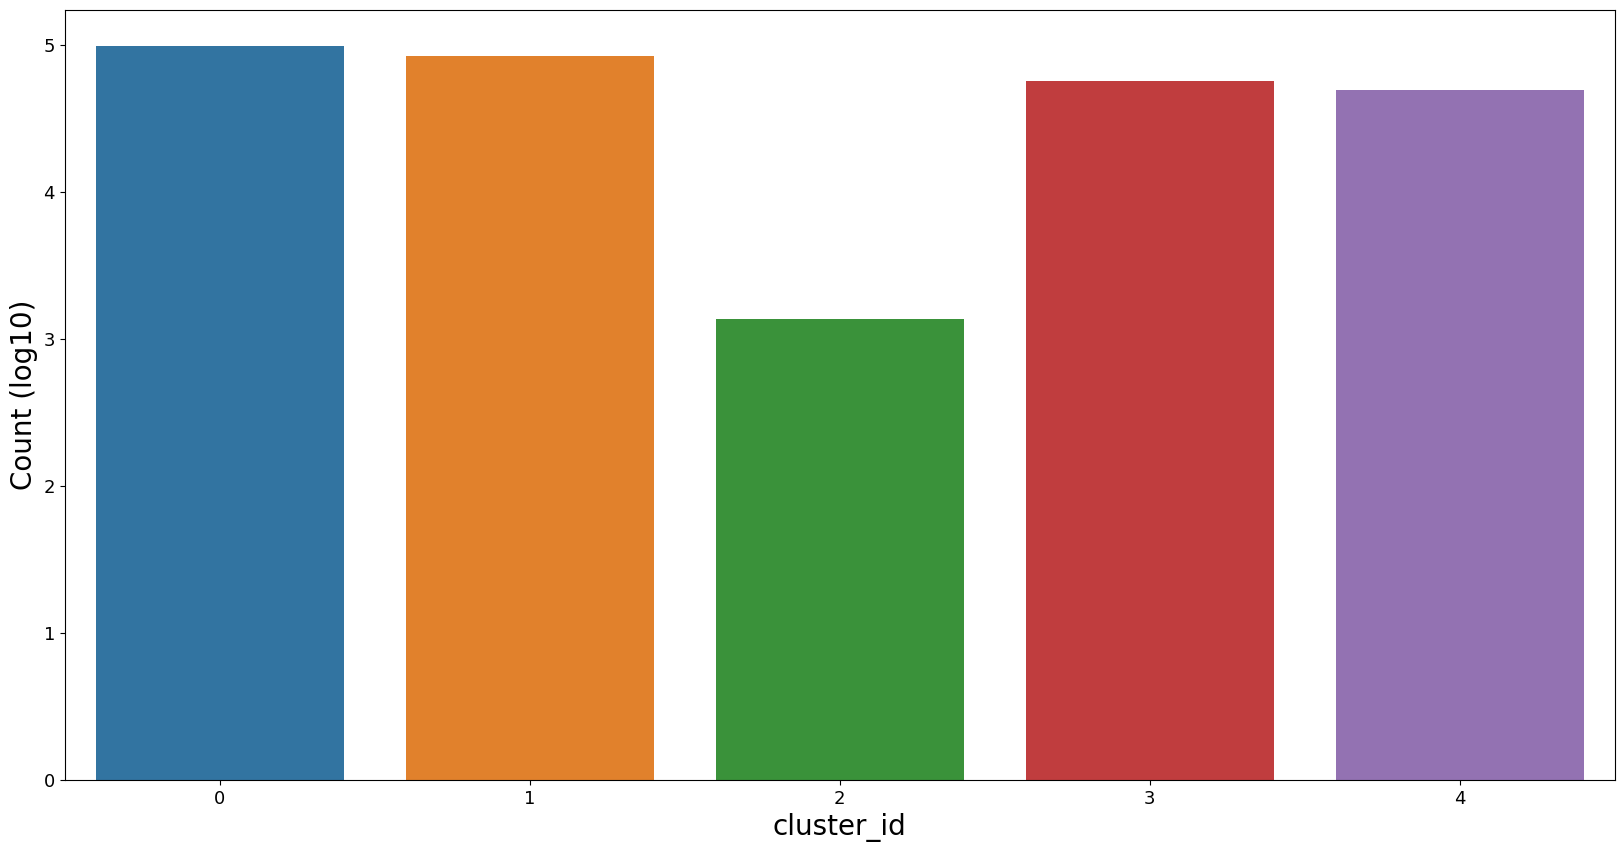

In [0]:
 sns.barplot(x=df_count.index, y=np.log10(df_count['cluster_id']))
sns.set(font_scale=3)
plt.xlabel('cluster_id',fontsize = 20)
plt.ylabel('Count (log10)', fontsize = 20)
plt.show()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
features = ['Vehicle_Type',	'Vehicle_Manoeuvre',	'Vehicle_Location-Restricted_Lane',	'Junction_Location',	'Skidding_and_Overturning',	'Hit_Object_in_Carriageway',	'Vehicle_Leaving_Carriageway',	'Hit_Object_off_Carriageway','1st_Point_of_Impact','Sex_of_Driver','Age_of_Driver',	'Age_Band_of_Driver',	'Engine_Capacity_(CC)',	'Propulsion_Code',	'Age_of_Vehicle',	'Driver_Home_Area_Type']    
# Separating out the features
x = df_dropped_na.loc[:, features].values
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5'])
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,0.772,2.067,-1.346,-0.362,-0.363
1,0.605,-1.276,-0.091,2.218,-0.799
2,2.508,-1.832,2.818,-1.770,0.244
3,0.778,-1.875,-1.687,0.193,-0.867
4,1.128,-1.563,-1.961,1.428,-1.279
...,...,...,...,...,...
290014,0.676,-0.318,2.152,0.356,-1.553
290015,1.789,-1.126,1.427,0.234,-0.174
290016,0.898,2.338,3.267,-0.213,-2.496
290017,4.986,1.585,-0.091,4.103,-2.617


In [0]:
pca.explained_variance_ratio_

array([0.14530468, 0.10424172, 0.09675958, 0.07037472, 0.06813551])

In [0]:
labels = finalDf[['cluster_id']]
labels.reset_index(drop=True, inplace=True)
finalDf = pd.concat([principalDf,labels], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,cluster_id
0,0.772,2.067,-1.346,-0.362,-0.363,1
1,0.605,-1.276,-0.091,2.218,-0.799,0
2,2.508,-1.832,2.818,-1.770,0.244,4
3,0.778,-1.875,-1.687,0.193,-0.867,3
4,1.128,-1.563,-1.961,1.428,-1.279,0
...,...,...,...,...,...,...
290014,0.676,-0.318,2.152,0.356,-1.553,4
290015,1.789,-1.126,1.427,0.234,-0.174,4
290016,0.898,2.338,3.267,-0.213,-2.496,4
290017,4.986,1.585,-0.091,4.103,-2.617,2


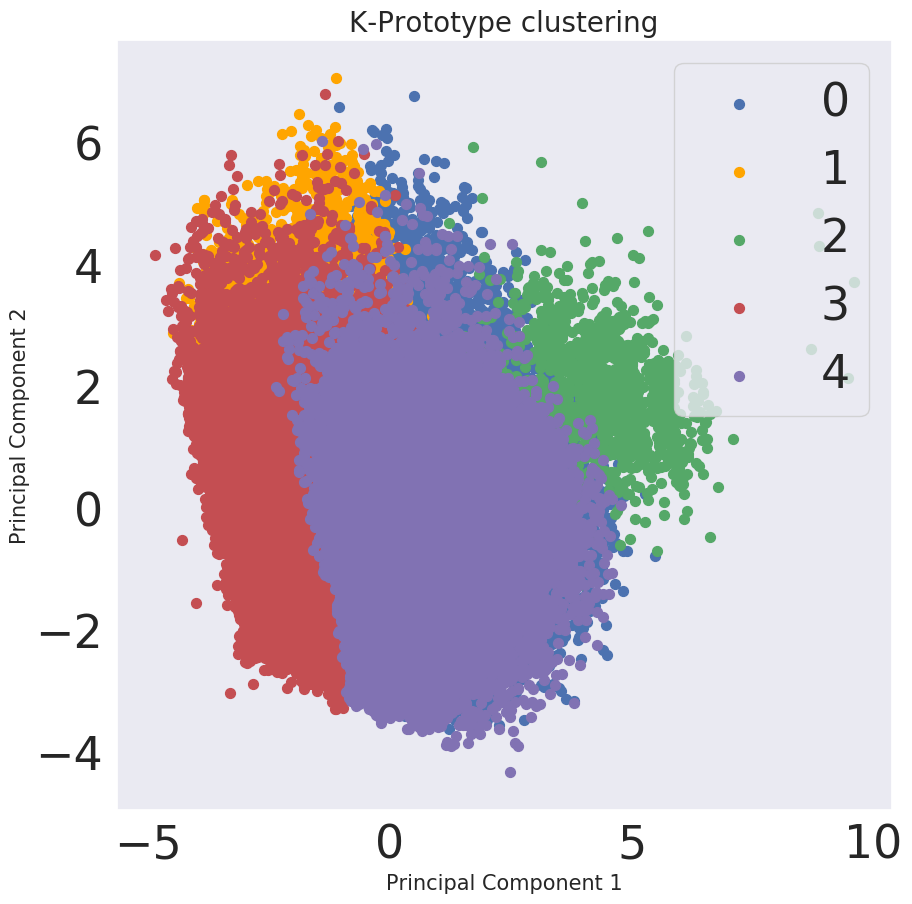

In [0]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('K-Prototype clustering', fontsize = 20)
targets = [0,1,2,3,4]
colors = ['b','orange','g', 'r', 'm']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

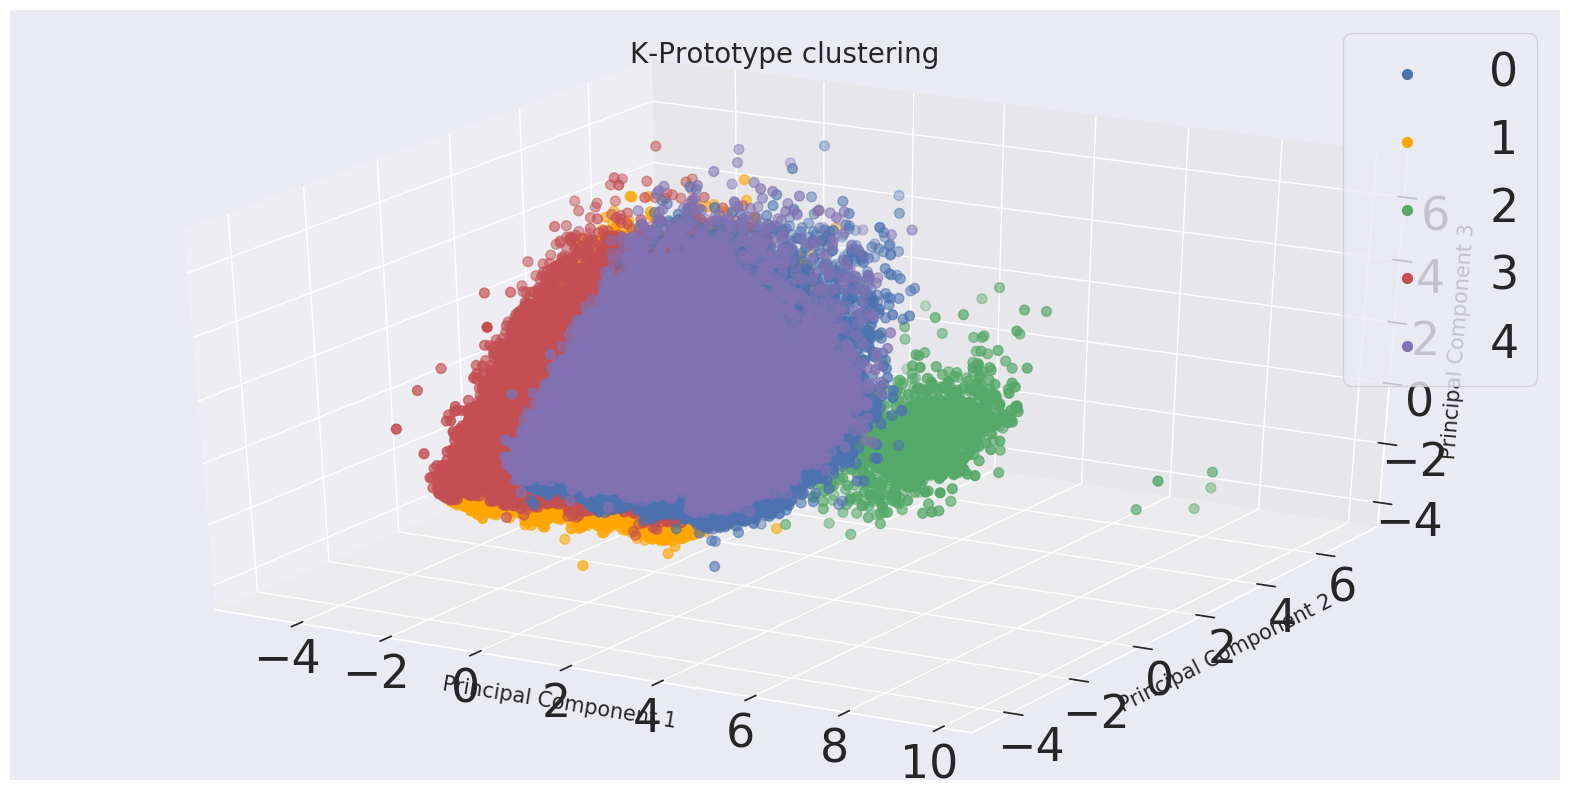

In [0]:
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.set_xlabel('Principal Component 1', fontsize = 15)
threedee.set_ylabel('Principal Component 2', fontsize = 15)
threedee.set_zlabel('Principal Component 3', fontsize = 15)
threedee.set_title('K-Prototype clustering', fontsize = 20)
targets = [0,1,2,3,4]
colors = ['b','orange','g', 'r', 'm']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster_id'] == target
    threedee.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
threedee.legend(targets)
threedee.grid()
plt.show()